In [2]:
import torch
import onnx
import pickle
from hpl.datamodule.DataLoader import preprocess_data, L96InferenceDataset
from torch.utils.data import DataLoader
import onnxruntime as ort
import matplotlib.pyplot as plt

/home/vadim/miniconda3/envs/hpl-torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Run from ONNX checkpoint

In [3]:
path_to_binary = "/home/vadim/Dev/hidden-process-learning/outputs/2023-03-13/15-29-44/logs/checkpoints/danet_9996.onnx"
model = onnx.load(path_to_binary)
onnx.checker.check_model(model)

FileNotFoundError: [Errno 2] No such file or directory: '/home/vadim/Dev/hidden-process-learning/outputs/2023-03-13/15-29-44/logs/checkpoints/danet_9996.onnx'

In [ ]:
path_to_data = "/home/vadim/Dev/hidden-process-learning/data/l96-1-65402354.pkl"
with open(path_to_data, "rb") as file:
    data = pickle.load(file)
    obs, mask = preprocess_data(data["x_obs"]);

In [4]:
dataset = L96InferenceDataset(obs, mask, [15, 15])
dataloader = DataLoader(dataset, shuffle=False)

NameError: name 'obs' is not defined

In [53]:
dataset = L96InferenceDataset(obs, mask, [15, 15])
dataloader = DataLoader(dataset, shuffle=False)
input = [sample for sample in dataloader]
input = torch.concat(input).numpy()
ort_session = ort.InferenceSession(path_to_binary)
predicted = ort_session.run(None, {"input": input})

In [68]:
input.shape

(500, 2, 30, 40)

In [54]:
ort_session = ort.InferenceSession(path_to_binary)
predicted = ort_session.run(None, {"input": input})

In [55]:
difference = data['x_true'].T - predicted[0].squeeze().T
limit = difference.abs().max()

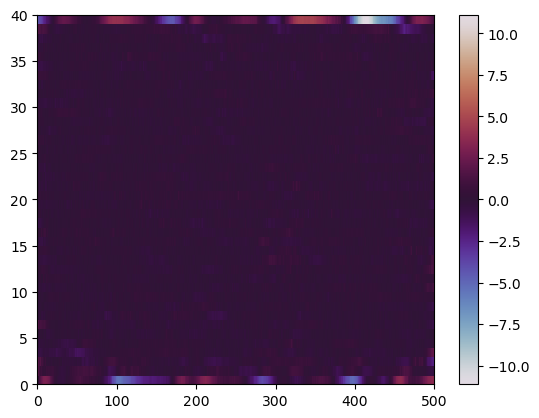

In [56]:
plt.pcolor(difference, cmap="twilight", vmin=-limit, vmax=limit)
plt.colorbar()

In [57]:
from torchmetrics import MeanSquaredError

In [58]:
rmse = MeanSquaredError(False)

In [59]:
target = data['x_true'].T
predictions = torch.from_numpy(predicted[0].squeeze().T)

In [60]:
running_rmse = [rmse(target[:, i], predictions[:, i]) for i in range(target.size(-1))]
running_rmse = torch.stack(running_rmse)

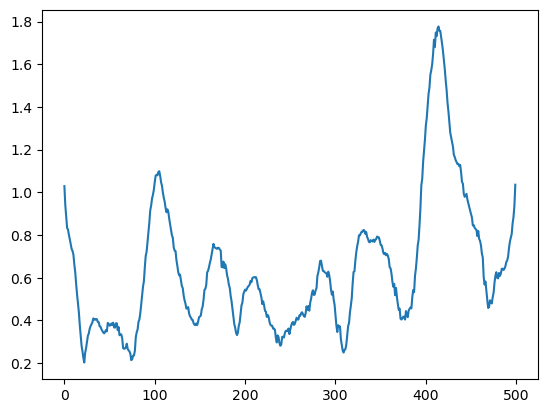

In [61]:
plt.plot(running_rmse)

# Run from PyTorch checkpoint

In [355]:
from omegaconf import OmegaConf, DictConfig
import os

import sys
sys.path.append("..")

In [356]:
from hpl.initializations import init_lightning_module

In [390]:
experiment_directory = "/home/vadim/Dev/hidden-process-learning/outputs/2023-03-13/20-47-13"

config = OmegaConf.load(os.path.join(experiment_directory, ".hydra/config.yaml"))

In [391]:
module = init_lightning_module(config)

In [392]:
def init_lightning_module_from_checkpoint(config: DictConfig, checkpoint: str):
    module = init_lightning_module(config)
    model = module.load_from_checkpoint(
        checkpoint,
        model=config.model,
        assimilation_network=config.assimilation_network,
        optimizer=config.optimizer,
        rollout_length=config.lightning_module.rollout_length,
        time_step=config.lightning_module.time_step,
        loss=config.lightning_module.loss,
    )
    return model

In [425]:
model = module.load_from_checkpoint(
    os.path.join(experiment_directory, "logs/checkpoints/epoch=30.ckpt"),
    model=config.model,
    assimilation_network=config.assimilation_network,
    optimizer=config.optimizer,
    rollout_length=config.lightning_module.rollout_length,
    time_step=config.lightning_module.time_step,
    loss=config.lightning_module.loss,
)

In [426]:
path_to_data = config.datamodule.path
with open(path_to_data, "rb") as file:
    data = pickle.load(file)
    obs, mask = preprocess_data(data["x_obs"]);

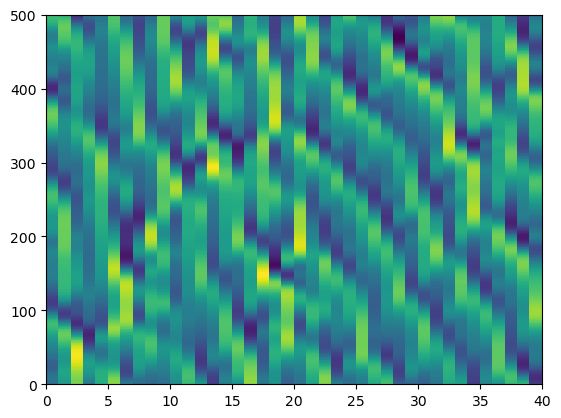

In [427]:
plt.pcolor(obs)

In [428]:
dataset = L96InferenceDataset(obs, mask, [15, 15])
dataloader = DataLoader(dataset, shuffle=False)

In [429]:
reconstruction = []
for input in dataloader:
    output = model.forward(input)
    reconstruction.append(output.detach())
reconstruction = torch.concat(reconstruction).squeeze()

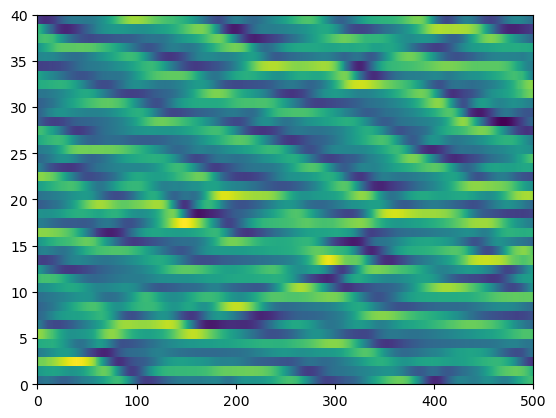

In [430]:
plt.pcolor(reconstruction.T)

In [431]:
difference = data['x_true'].T - reconstruction.T
limit = difference.abs().max()

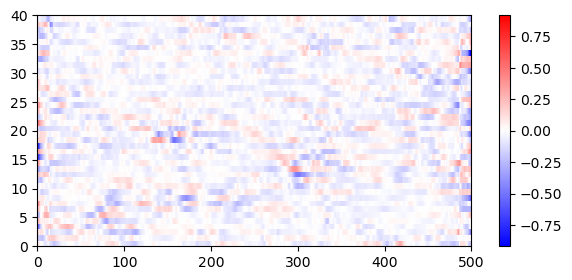

In [432]:
fig = plt.figure(figsize=(7, 3))
plt.pcolor(difference, cmap="bwr", vmin=-limit, vmax=limit)
plt.colorbar()

In [433]:
from torchmetrics import MeanSquaredError, MeanAbsoluteError, R2Score
import numpy as np

In [434]:
rmse = MeanSquaredError(False)

target = data['x_true'].T
predictions = reconstruction.T
rmse_true = [rmse(target[:, i], predictions[:, i]) for i in range(target.size(-1))]
rmse_true = torch.stack(rmse_true)


r2 = R2Score(500)
print(r2(target, predictions))

target = obs.T
mask_local = mask.T
rmse_obs = []
for i in range(target.size(-1)):
    if mask_local[:, i].sum() == 0:
        rmse_obs.append(np.nan)
    else:
        rmse_obs.append(rmse(
            torch.masked_select(target[:, i], mask_local[:, i]),
            torch.masked_select(predictions[:, i], mask_local[:, i])
        ).item())
rmse_obs = torch.tensor(rmse_obs)

tensor(0.9994)


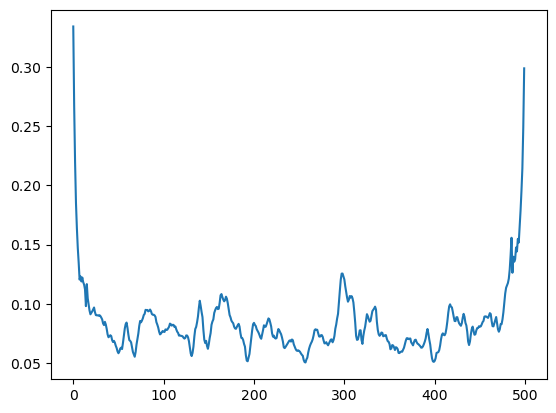

In [435]:
plt.plot(rmse_true)
# plt.plot(rmse_obs)